In [2]:
# Imports
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [3]:
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
# Define paths
base_path = "/Users/omripeer/Documents/Omri/תואר ראשון במדעי המחשב - מכללת אפקה/שנים א-ג/שנה ג/Final Project/ML Model"
images_path = os.path.join(base_path, "images")
labels_path = os.path.join(base_path, "annotations", "obj_train_data")
crops_dir = os.path.join(base_path, "crops")
os.makedirs(crops_dir, exist_ok=True)  # Create crops folder if doesn't exist

In [6]:
# Function to draw bounding boxes
def plot_image_with_boxes(image, labels):
    image_with_boxes = image.copy()
    height, width, _ = image.shape

    for label in labels:
        parts = label.strip().split()
        if len(parts) != 5:
            continue
        class_id, x_center, y_center, box_width, box_height = map(float, parts)

        x_center_pixel = x_center * width
        y_center_pixel = y_center * height
        box_width_pixel = box_width * width
        box_height_pixel = box_height * height

        x_min = int(x_center_pixel - box_width_pixel / 2)
        y_min = int(y_center_pixel - box_height_pixel / 2)
        x_max = int(x_center_pixel + box_width_pixel / 2)
        y_max = int(y_center_pixel + box_height_pixel / 2)

        cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.putText(image_with_boxes, str(int(class_id)), (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    return image_with_boxes


In [7]:
# Function to save crops
def save_crops_from_labels(image, labels, crops_dir, starting_idx=0):
    height, width, _ = image.shape
    data = []

    for idx, label in enumerate(labels):
        parts = label.strip().split()
        if len(parts) != 5:
            continue

        class_id, x_center, y_center, box_width, box_height = map(float, parts)

        x_center_pixel = x_center * width
        y_center_pixel = y_center * height
        box_width_pixel = box_width * width
        box_height_pixel = box_height * height

        x_min = int(x_center_pixel - box_width_pixel / 2)
        y_min = int(y_center_pixel - box_height_pixel / 2)
        x_max = int(x_center_pixel + box_width_pixel / 2)
        y_max = int(y_center_pixel + box_height_pixel / 2)

        # Crop the region
        crop = image[max(0, y_min):min(height, y_max), max(0, x_min):min(width, x_max)]

        # Define filename
        crop_filename = f"crop_{starting_idx + idx}_class_{int(class_id)}.png"
        crop_path = os.path.join(crops_dir, crop_filename)

        # Save crop
        pil_crop = Image.fromarray(crop)
        pil_crop.save(crop_path)

        # Add entry for CSV
        data.append({
            "crop_filename": crop_filename,
            "class_id": class_id
        })

    return data


✅ Loaded image VID2830_A1_2_00d00h00m.tif with shape (1040, 1408, 3)
✅ Loaded 217 labels for VID2830_A1_2_00d00h00m.txt


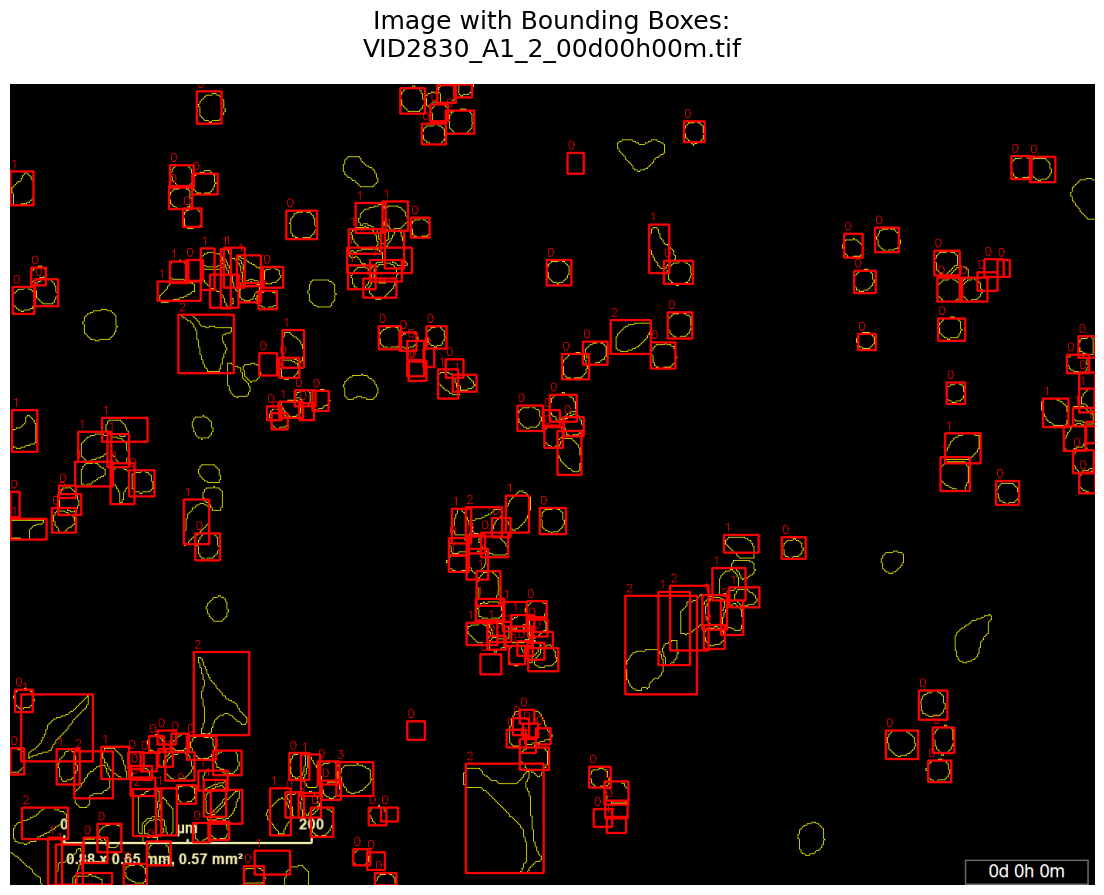

✅ Saved image with bounding boxes to /Users/omripeer/Documents/Omri/תואר ראשון במדעי המחשב - מכללת אפקה/שנים א-ג/שנה ג/Final Project/ML Model/output_with_boxes_VID2830_A1_2_00d00h00m.png
✅ Loaded image VID2830_A1_9_00d00h00m.tif with shape (1040, 1408, 3)
✅ Loaded 211 labels for VID2830_A1_9_00d00h00m.txt


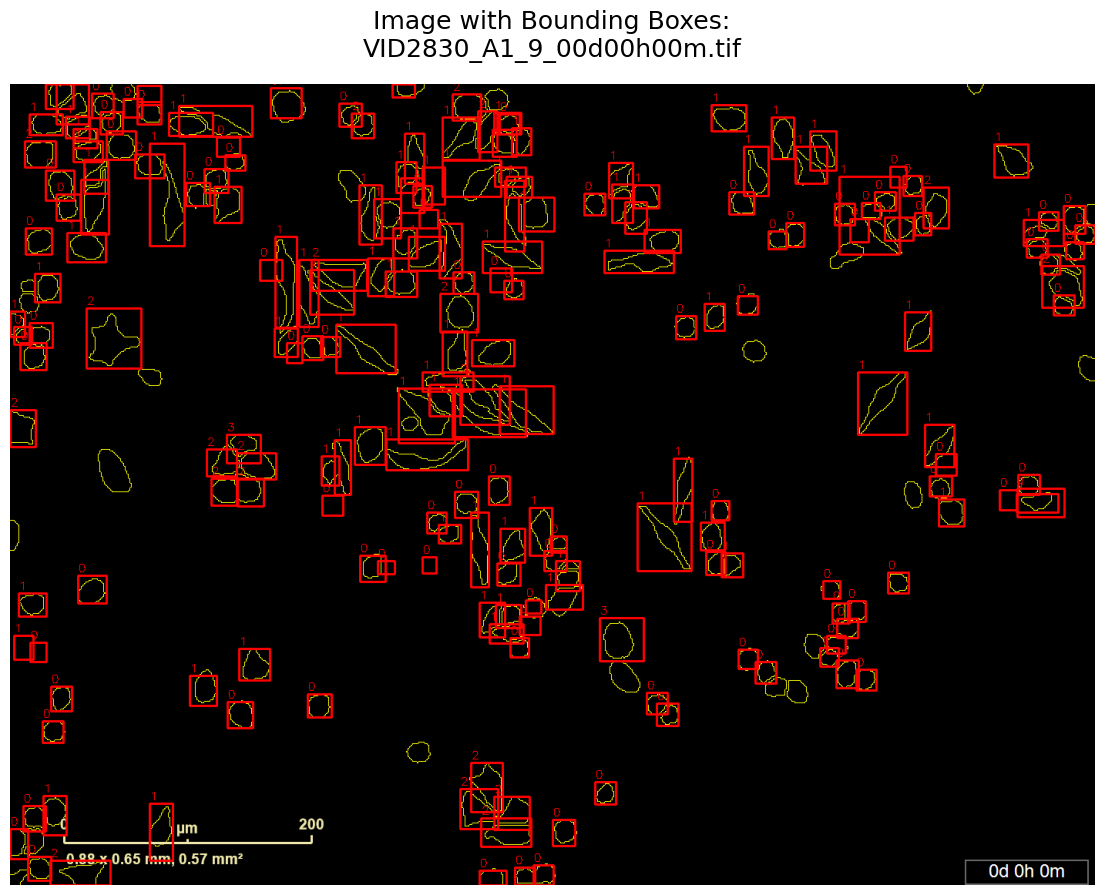

✅ Saved image with bounding boxes to /Users/omripeer/Documents/Omri/תואר ראשון במדעי המחשב - מכללת אפקה/שנים א-ג/שנה ג/Final Project/ML Model/output_with_boxes_VID2830_A1_9_00d00h00m.png


In [8]:
# --- קובץ ראשי להעלאת תמונות והצגת תיבות תחימה ---

# List of image/label pairs
images_and_labels = [
    ("VID2830_A1_2_00d00h00m.tif", "VID2830_A1_2_00d00h00m.txt"),
    ("VID2830_A1_9_00d00h00m.tif", "VID2830_A1_9_00d00h00m.txt"),
]

all_data = []
global_idx = 0

for image_filename, label_filename in images_and_labels:
    # Load the image
    image_path = os.path.join(images_path, image_filename)
    pil_image = Image.open(image_path)
    image = np.array(pil_image)

    print(f"✅ Loaded image {image_filename} with shape {image.shape}")

    # Load labels
    label_path = os.path.join(labels_path, label_filename)
    with open(label_path, "r") as file:
        labels = file.readlines()

    print(f"✅ Loaded {len(labels)} labels for {label_filename}")

    # Draw bounding boxes
    image_with_boxes = plot_image_with_boxes(image, labels)

    # --- Display the image nicely ---
    dpi = 100
    height, width, _ = image_with_boxes.shape
    figsize = (width / dpi, height / dpi)

    fig, ax = plt.subplots(figsize=figsize)
    _ = ax.imshow(image_with_boxes)  # למנוע הדפסת AxesImage
    _ = ax.axis("off")               # למנוע הדפסת True
    _ = ax.set_title(f"Image with Bounding Boxes:\n{image_filename}", fontsize=18, pad=20)
    _ = plt.show()                   # גם פה לשמור ל-_
    plt.close(fig)                   # סגירה נקייה
    # -----------------------------------

    # Save image
    save_path = os.path.join(base_path, f"output_with_boxes_{image_filename.replace('.tif', '.png')}")
    _ = cv2.imwrite(save_path, cv2.cvtColor(image_with_boxes, cv2.COLOR_RGB2BGR))
    print(f"✅ Saved image with bounding boxes to {save_path}")

    # Save crops and accumulate data
    data = save_crops_from_labels(image, labels, crops_dir, starting_idx=global_idx)
    all_data.extend(data)
    global_idx += len(data)


In [9]:
# Define class names
class_names = ["Resting", "Surveilling", "Activated", "Resolution"]

# Create dataframe
df = pd.DataFrame(all_data)

# 🔥 Convert class_id to integer
df["class_id"] = df["class_id"].astype(int)

# Add class names
df["class_name"] = df["class_id"].apply(lambda x: class_names[x])

# Save to CSV
csv_save_path = os.path.join(base_path, "crops_labels.csv")
df.to_csv(csv_save_path, index=False)

print(f"✅ CSV file saved successfully to {csv_save_path}")


✅ CSV file saved successfully to /Users/omripeer/Documents/Omri/תואר ראשון במדעי המחשב - מכללת אפקה/שנים א-ג/שנה ג/Final Project/ML Model/crops_labels.csv


In [10]:
# Check all crops exist
missing_files = []

for filename in df["crop_filename"]:
    crop_path = os.path.join(crops_dir, filename)
    if not os.path.exists(crop_path):
        missing_files.append(filename)

if missing_files:
    print(f"⚠️ Missing {len(missing_files)} crop files:")
    print(missing_files)
else:
    print("✅ All crop files found!")


✅ All crop files found!


In [11]:
# --- Train / Validation / Test split ---

# First split into Train+Val and Test
train_val_df, test_df = train_test_split(
    df,
    test_size=0.15,  # 15% for final test
    random_state=42,
    stratify=df["class_id"]
)

# Now split Train+Val into Train and Validation
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,  # 20% of 85% (≈17% of total)
    random_state=42,
    stratify=train_val_df["class_id"]
)

print(f"✅ Split completed:")
print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")


✅ Split completed:
Train samples: 290
Validation samples: 73
Test samples: 65


In [12]:
import shutil

# Function to copy images to the appropriate directory
def copy_crops(df, target_dir):
    for filename in df["crop_filename"]:
        src = os.path.join(crops_dir, filename)  # מקור התמונה
        dst = os.path.join(target_dir, filename)  # יעד התמונה
        if os.path.exists(src):
            shutil.copy(src, dst)
        else:
            print(f"⚠️ Warning: File {filename} not found!")

train_crops_dir = os.path.join(base_path, "train_crops")
val_crops_dir = os.path.join(base_path, "val_crops")

# לדאוג שהתיקיות קיימות
os.makedirs(train_crops_dir, exist_ok=True)
os.makedirs(val_crops_dir, exist_ok=True)

# ואז להמשיך:
copy_crops(train_df, train_crops_dir)
copy_crops(val_df, val_crops_dir)


# Copy train crops
copy_crops(train_df, train_crops_dir)

# Copy validation crops
copy_crops(val_df, val_crops_dir)

# Create test_crops folder
test_crops_dir = os.path.join(base_path, "test_crops")
os.makedirs(test_crops_dir, exist_ok=True)

# Copy test crops
copy_crops(test_df, test_crops_dir)
print("✅ Test crops copied successfully.")


✅ Test crops copied successfully.


In [13]:
# --- Custom Dataset Class ---
class CropsDataset(Dataset):
    def __init__(self, dataframe, images_dir, transform=None):
        self.data = dataframe  # <-- Instead of loading from CSV, receive a dataframe directly
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.images_dir, row["crop_filename"])  # Path is built from crops_dir + filename
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        label = int(row["class_id"])  # class_id is integer
        return image, label


In [14]:
# --- Define Improved Transformations ---
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_val = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])



In [15]:
# --- Create Datasets and Dataloaders (with new transforms) ---

train_dataset = CropsDataset(train_df, images_dir=train_crops_dir, transform=transform_train)
val_dataset = CropsDataset(val_df, images_dir=val_crops_dir, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Add Test Dataset
test_dataset = CropsDataset(test_df, images_dir=test_crops_dir, transform=transform_val)

# Add Test Dataloader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("✅ Updated Dataloaders with Augmentation ready!")


✅ Updated Dataloaders with Augmentation ready!


In [16]:
# --- Define a Simple CNN Model ---
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.5),        # הוספת Dropout
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [17]:
# --- Create model, define loss and optimizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 4  # Resting, Surveilling, Activated, Resolution
model = SimpleCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# הוספת Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

print(f"✅ Model, criterion and optimizer ready! Running on {device}.")


✅ Model, criterion and optimizer ready! Running on cpu.


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [18]:
# --- Define the training function ---
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct_predictions / len(dataloader.dataset)

    return epoch_loss, epoch_accuracy


# --- Define the validation function ---
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct_predictions / len(dataloader.dataset)

    return epoch_loss, epoch_accuracy


In [19]:
# --- Create Dataloaders ---
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"✅ Dataloaders ready! {len(train_loader.dataset)} train samples, {len(val_loader.dataset)} val samples.")


✅ Dataloaders ready! 290 train samples, 73 val samples.


In [47]:
# --- Training Loop with Early Stopping and Best Model Saving ---
num_epochs = 30
patience = 7  # שיניתי ל-7
best_val_acc = 0.0  # Track the best validation accuracy
epochs_without_improvement = 0

best_model_wts = model.state_dict()  # Save initial weights just in case

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # להפעיל Scheduler אחרי קבלת val_loss
    scheduler.step(val_loss)

    print(f"📅 Epoch {epoch+1}/{num_epochs}")
    print(f"    🏋️‍♂️ Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"    🔍 Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    # Check if current model is the best so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = model.state_dict()  # Save model weights
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"⏹️ Early stopping triggered at epoch {epoch+1}")
            break

# After training, load the best weights
model.load_state_dict(best_model_wts)
print(f"✅ Best Validation Accuracy: {best_val_acc:.4f} - Loaded best model weights!")

# (Optional) Save the best model to disk
torch.save(model.state_dict(), os.path.join(base_path, "best_model.pth"))
print("💾 Best model saved to best_model.pth")

# --- Final Test Evaluation ---
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"🧪 Final Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")


📅 Epoch 1/30
    🏋️‍♂️ Train Loss: 0.6371, Accuracy: 0.7103
    🔍 Val Loss: 0.5070, Accuracy: 0.7671
📅 Epoch 2/30
    🏋️‍♂️ Train Loss: 0.6531, Accuracy: 0.7276
    🔍 Val Loss: 0.4983, Accuracy: 0.7534
📅 Epoch 3/30
    🏋️‍♂️ Train Loss: 0.5593, Accuracy: 0.7379
    🔍 Val Loss: 0.4960, Accuracy: 0.7534
📅 Epoch 4/30
    🏋️‍♂️ Train Loss: 0.6720, Accuracy: 0.7276
    🔍 Val Loss: 0.4956, Accuracy: 0.7671
📅 Epoch 5/30
    🏋️‍♂️ Train Loss: 0.5409, Accuracy: 0.7483
    🔍 Val Loss: 0.4953, Accuracy: 0.7534
📅 Epoch 6/30
    🏋️‍♂️ Train Loss: 0.5949, Accuracy: 0.7138
    🔍 Val Loss: 0.4950, Accuracy: 0.7534
📅 Epoch 7/30
    🏋️‍♂️ Train Loss: 0.6103, Accuracy: 0.7172
    🔍 Val Loss: 0.4956, Accuracy: 0.7671
📅 Epoch 8/30
    🏋️‍♂️ Train Loss: 0.5990, Accuracy: 0.7345
    🔍 Val Loss: 0.4973, Accuracy: 0.7671
⏹️ Early stopping triggered at epoch 8


<All keys matched successfully>

✅ Best Validation Accuracy: 0.7671 - Loaded best model weights!
💾 Best model saved to best_model.pth
🧪 Final Test Loss: 0.4099, Accuracy: 0.8154
